In [ ]:
%cd /content/drive/MyDrive/AI_healthcare/Val

/content/drive/MyDrive/AI_healthcare/Val


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as albu
from skimage.transform import resize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import tensorflow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

(1024, 1024)

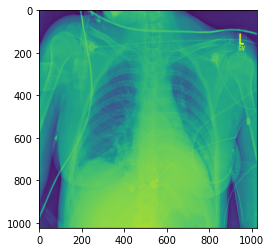

In [ ]:
from google.colab.patches import cv2_imshow
a = cv2.imread('/content/drive/MyDrive/AI_healthcare/dataste/CXR_train_4.png',cv2.IMREAD_UNCHANGED)
plt.imshow(a)
a.shape

In [ ]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "/content/drive/MyDrive/AI_healthcare/dataste/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: user 293 ms, sys: 35.9 ms, total: 329 ms
Wall time: 470 ms


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

[]
________________________________________________
False


In [ ]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.9.2


In [ ]:
%%time

train_df = os.listdir("/content/drive/MyDrive/AI_healthcare/dataste/")
test_df = os.listdir("/content/drive/MyDrive/AI_healthcare/normal/")
validation_df = os.listdir("/content/drive/MyDrive/AI_healthcare/Val/")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: user 2.84 ms, sys: 1.17 ms, total: 4.01 ms
Wall time: 71.9 ms


In [ ]:


train_df[:5], test_df[:5]



(['CXR_train_1603.png',
  'CXR_train_210.png',
  'CXR_train_1729.png',
  'CXR_train_2101.png',
  'CXR_train_172.png'],
 ['CXR_train_33.png',
  'CXR_train_390.png',
  'CXR_train_423.png',
  'CXR_train_96.png',
  'CXR_train_492.png'])

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 2150 images in the training dataset
There is 1365 images in the test dataset
There is 22 images in the validation dataset


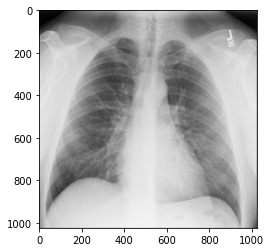

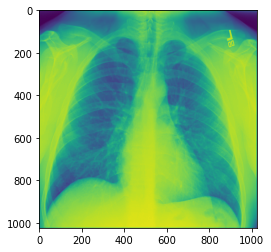

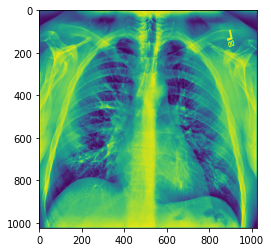

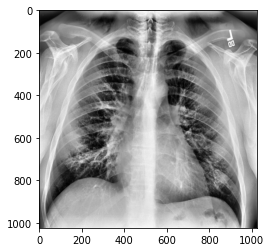

In [ ]:
path = "/content/drive/MyDrive/AI_healthcare/dataste"
count = 0
for img in (os.listdir(path)):
    
    bgr_img = cv2.imread(os.path.join(path,img))
    
    image_bw = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    rbg_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.imshow(rbg_img)
    plt.show()
    plt.imshow(image_bw)
    plt.show()
  
    clahe = cv2.createCLAHE(clipLimit = 5)
    final_img = clahe.apply(image_bw)

    #Finding ends for croping
    plt.imshow(final_img)
    plt.show()
    img_processed = (np.array(final_img)-6)/255
      
    variance=1
    col_sum = np.sum(img_processed, axis=0)
    row_sum = np.sum(img_processed, axis=1)
    coordx = []
    coordy = []
    for i,j in enumerate(col_sum):
        if j>variance:
            coordx.append(i)
    for i,j in enumerate(row_sum):
        if j>variance:
            coordy.append(i)
    

    final_img = final_img[coordy[0]:coordy[-1]:, coordx[0]:coordx[-1]]
    img_size = 1024
    gray_three = cv2.merge([final_img,final_img,final_img])
    gray_three = cv2.resize(gray_three, (img_size,img_size))
    plt.imshow(gray_three)
    plt.show()
    break
    

In [ ]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights = "imagenet",
                                                       input_shape = (224, 224, 3),
                                                       pooling = "max", include_top = False,
                                                       classes = 2)

for layer in base_model2.layers:
    layer.trainable = False
    
#base_model2.summary()

94668760/94668760 [==============================] - 4s 0us/step


In [ ]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())

model3.add(Dense(128, activation = "relu"))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(32, activation = "relu"))
model3.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model2.layers:
    layer.trainable = False

model3.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:


%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)



CPU times: user 26 µs, sys: 4 µs, total: 30 µs
Wall time: 34.6 µs


In [ ]:
%%time

history = model3.fit_generator(train_set, epochs = 20, validation_data = validation_set, steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

In [ ]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)
path = "/content/drive/MyDrive/AI_healthcare/dataste"
train_set = train_datagen.flow_from_directory(path, class_mode = "binary", batch_size = 16, target_size = (1024, 1024))
validation_set = val_test_datagen.flow_from_directory(validation_df, class_mode = "binary", batch_size = 16, target_size = (1024,1024))
test_set = val_test_datagen.flow_from_directory(path, class_mode = "binary", batch_size = 16, target_size = (1024, 1024))

In [ ]:
import os
Train_images=[]
Train_image_labels=[]

%cd /content/drive/MyDrive/AI_healthcare/normal

for image in os.listdir():
    image = cv2.imread("/content/drive/MyDrive/AI_healthcare/normal"+"/"+image)
    image=cv2.resize(image,(28,28))
    Train_images.append(image)
    Train_image_labels.append(0)

%cd /content/drive/MyDrive/AI_healthcare/pneumonia
for image in os.listdir():
    image = cv2.imread("/content/drive/MyDrive/AI_healthcare/pneumonia"+"/"+image)
    image=cv2.resize(image,(28,28))
    Train_images.append(image)
    Train_image_labels.append(1)

/content/drive/MyDrive/AI_healthcare/normal
/content/drive/MyDrive/AI_healthcare/pneumonia


In [ ]:

import tensorflow as tf
import cv2
import numpy as np

from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split

In [ ]:
import os
Train_images=[]
Train_image_labels=[]

%cd /content/drive/MyDrive/AI_healthcare/normal

for image in os.listdir():
    image = cv2.imread("/content/drive/MyDrive/AI_healthcare/normal"+"/"+image)
    image=cv2.resize(image,(28,28))
    Train_images.append(image)
    Train_image_labels.append(0)

%cd /content/drive/MyDrive/AI_healthcare/pneumonia
for image in os.listdir():
    image = cv2.imread("/content/drive/MyDrive/AI_healthcare/pneumonia"+"/"+image)
    image=cv2.resize(image,(28,28))
    Train_images.append(image)
    Train_image_labels.append(1)

/content/drive/MyDrive/AI_healthcare/normal
/content/drive/MyDrive/AI_healthcare/pneumonia


In [ ]:
np_X=np.array(Train_images)
np_Y=np.array(Train_image_labels)
xtrain,xtest,ytrain,ytest=train_test_split(np_X.astype('float32')/255.0 , np_Y,shuffle=True,test_size=0.3)
ytrain=np.array(ytrain)
ytest=np.array(ytest)

In [ ]:
print(len(Train_image_labels))

2104


In [ ]:
model = Sequential()
#First Convolution Layer
#Learning a total of 32 filters , which is then downsampled by maxpooling layer (2x2)
#kernel_size 3x3 : specifying height and width of 2D convolution window
#padding same: spatial dimensions such that: output value size matches the input volume size
#Relu: activation function used
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Second Convolution Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(28, 28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Third Convolution Layer
model.add(Conv2D(128, (3, 3), padding='same', input_shape=(28, 28,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Batch normalization  allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers.
#Flattening : converting 2d array into single long continuous vector
#Dropouts used to avoid overfitting
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
#Dense layers produce the output = activation(dot(input, kernel) + bias)
#Used to predict labels
#Sigmoid activation function used for all dense layers for constructing desired decision boundary
model.add(Dense(512,activation='sigmoid'))
model.add(Dense(128,activation='sigmoid'))
model.add(Dense(32,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))

#optimizer: Adam, loss:Binary_CrossEntropy, metrics: accuracy
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy',metrics=['accuracy'])

#Fitting Training data in Model
history = model.fit(xtrain, ytrain, batch_size=16, epochs=50, validation_split=0.2 ,shuffle = True, verbose=1)


Epoch 1/50
74/74 [==============================] - 5s 52ms/step - loss: 0.6325 - accuracy: 0.6559 - val_loss: 0.6803 - val_accuracy: 0.6068
Epoch 2/50
74/74 [==============================] - 4s 48ms/step - loss: 0.6233 - accuracy: 0.6474 - val_loss: 0.6796 - val_accuracy: 0.6068
Epoch 3/50
74/74 [==============================] - 3s 47ms/step - loss: 0.6019 - accuracy: 0.6848 - val_loss: 0.6378 - val_accuracy: 0.6305
Epoch 4/50
74/74 [==============================] - 3s 46ms/step - loss: 0.5958 - accuracy: 0.6890 - val_loss: 0.6368 - val_accuracy: 0.6203
Epoch 5/50
74/74 [==============================] - 3s 46ms/step - loss: 0.5865 - accuracy: 0.6882 - val_loss: 0.6882 - val_accuracy: 0.5186
Epoch 6/50
74/74 [==============================] - 4s 47ms/step - loss: 0.5842 - accuracy: 0.6967 - val_loss: 0.6437 - val_accuracy: 0.6542
Epoch 7/50
74/74 [==============================] - 3s 47ms/step - loss: 0.5722 - accuracy: 0.7043 - val_loss: 0.6351 - val_accuracy: 0.6475
Epoch 8/50
74

In [ ]:
#model.save("ProjectModel.h5")
%cd /content/drive/MyDrive
!mkdir -p saved_model
model.save('saved_model/my_model1')

/content/drive/MyDrive


In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/saved_model/my_model1')

test_loss,test_acc=model.evaluate(xtest,ytest)
print("TestAccuracy:",test_acc)
print("TestLoss:",test_loss)

20/20 [==============================] - 1s 23ms/step - loss: 1.3868 - accuracy: 0.6456
TestAccuracy: 0.6455696225166321
TestLoss: 1.3868097066879272
